# Generate Structured and Annotated Data from Syris

In [153]:
from rdflib import Graph,Namespace
from rdflib import URIRef,BNode,Literal
from rdflib.namespace import RDF
from rdflib.namespace import RDFS, FOAF

from decimal import Decimal
from pandas import Timedelta

import json, requests 

In [154]:

syrisurl = "https://syris.iigweb.hevs.ch/"
mediaurl = syrisurl+"media/"
allroutesurl = syrisurl+"en/routes/getallroutes"


alldata = json.loads(requests.get(allroutesurl).text)
ids = [f['properties']['pk'] for f in alldata['features']]
print(ids)


['2955', '2894', '2969', '2937', '2952', '2930', '2902', '2935', '2887', '2901', '2931', '2949', '2958', '2959', '2961', '2962', '2905', '2966', '2968', '2897', '2932', '2900', '2888', '2934', '2917', '2904', '2945', '2912', '2963', '2964', '2907', '2967', '2906', '2965', '2946', '2954', '2911', '2903', '2886', '2957', '2908', '2913', '2915', '2914', '2916', '2892', '2921', '2891', '2893', '2922', '2899', '2944', '2898', '2896', '2933', '2910', '2909', '2919', '2920', '2928', '2929', '2924', '2925', '2926', '2927', '2948', '2947', '2936', '2939', '2940', '2941', '2938', '2942', '2943', '2951', '2950', '2953', '2956', '2889']


In [155]:
ANNIVIERS= Namespace("https://hevs.ch/santour/anniviers/")
SANTOUR= Namespace("https://hevs.ch/ontology/santour#")
SCHEMA = Namespace("https://schema.org/")
QUDT = Namespace("http://qudt.org/vocab/unit/")

In [156]:
g = Graph()

g.bind("schema",SCHEMA)
g.bind("santour",SANTOUR)
g.bind("anniviers",ANNIVIERS)
g.bind("qudt",QUDT)

In [163]:


def addPropertyValue(subject,iri,value,unit=None):
    feature = BNode()
    g.add( (feature, SCHEMA.value, Literal(value) ) )
    g.add( (feature, SCHEMA.propertyID, iri ) )
    if unit != None:
        g.add( (feature, SCHEMA.unitCode, unit ) )
    return feature


def addAmenityFeature(subject,iri,value,unit=None):
    feature = BNode()
    g.add( (subject, SCHEMA.amenityFeature, feature) )
    g.add( (feature, RDF.type, SCHEMA.LocationFeatureSpecification) )
    g.add( (feature, SCHEMA.value, Literal(value) ) )
    g.add( (feature, SCHEMA.propertyID, iri ) )
    if unit != None:
        g.add( (feature, SCHEMA.unitCode, unit ) )
 

In [164]:
def getRoute(id):
    routesurl = syrisurl+"en/routes/route_data/"+id
    url = requests.get(routesurl)
    data = json.loads(url.text)
    features = data['features']

    route =[f for f in features if "duration" in f['properties']][0]
    pods = [f for f in features if "img" in f['properties'] ]
    return (route,pods)
    


In [165]:
def generatePod(g,routeIri,pod):
    pod_prop=pod['properties']

    podid=pod_prop['pk']

    podIri = URIRef(ANNIVIERS+'pod_'+podid)

    geopod=pod['geometry']['coordinates']
    print(geopod)
    
    g.add( (routeIri, SCHEMA.containsPlace, podIri ) )
    g.add( (routeIri, SANTOUR.hasPointOfDifficulty, podIri ) )
    
    g.add( (podIri, RDF.type, SANTOUR.PointOfDifficulty ) )
    g.add( (podIri, RDF.type, SCHEMA.Place ) )
    g.add( (podIri, SCHEMA.name, Literal(pod_prop['title']) ) )
    g.add( (podIri, SCHEMA.description, Literal(pod_prop['description']) ) )
    g.add( (podIri, SCHEMA.identifier, Literal(pod_prop['pk']) ) )
    #g.add( (podIri, SANTOUR.risk, Literal(int(pod_prop['risk']) )) )
    #g.add( (podIri, SANTOUR.technique, Literal(int(pod_prop['technical']) )) )
    g.add( (podIri, SCHEMA.image, URIRef(mediaurl+pod_prop['img']) ) )
    
    
    addAmenityFeature(podIri,SANTOUR.risk,int(pod_prop['risk']))
    addAmenityFeature(podIri,SANTOUR.technique,int(pod_prop['technical']))
    
    podGeo = BNode()
    g.add( (podIri, SCHEMA.geo, podGeo) )
    g.add( (podGeo, RDF.type, SCHEMA.GeoCoordinates) )
    g.add( (podGeo, SCHEMA.latitude, Literal(Decimal(str(geopod[1]) ) )) )
    g.add( (podGeo, SCHEMA.longitude, Literal(Decimal(str (geopod[0]) ) )) )
    
    

In [166]:
def generateRoute(g,id):
    (route,pods) = getRoute(id)
    route_prop=route['properties']

    routeIri = URIRef(ANNIVIERS+'route_'+id)


    georoute=route['geometry']['coordinates']
    gg=georoute[0]

    coordlistcoordlist = [str(coord[0])+' '+ str(coord[1]) for coord in gg]
    wkt=', '.join(coordlist)
        
    g.add( (routeIri, RDF.type, SANTOUR.Route ) )
    g.add( (routeIri, RDF.type, SCHEMA.Place ) )
    g.add( (routeIri, SCHEMA.name, Literal(route_prop['title']) ) )
    g.add( (routeIri, SCHEMA.identifier, Literal(route_prop['pk']) ) )
    g.add( (routeIri, SCHEMA.url, URIRef(route_prop['subtitle']) ) )
    g.add( (routeIri, SCHEMA.description, Literal(route_prop['description']) ) )

    action = BNode()
    exPlan = BNode()
    g.add( (routeIri, SCHEMA.potentialAction, action) )
    g.add( (action, RDF.type, SCHEMA.ExerciseAction) )

    distance = addPropertyValue(action,SCHEMA.Distance,Decimal(route_prop['tour_length']),QUDT.KiloM)
    g.add( (action, SCHEMA.distance, distance  ) )

    g.add( (action, SCHEMA.exercisePlan, exPlan  ) )

    durationHM = route_prop['duration'].split(':')
    duration = Timedelta(hours=int(durationHM[0]),minutes=int(durationHM[1])).isoformat()

    g.add( (exPlan, SCHEMA.activityDuration, Literal(duration) ) )
   
    addAmenityFeature(routeIri,SANTOUR.ascent,int(route_prop['ascent']),QUDT.M)
    addAmenityFeature(routeIri,SANTOUR.descent,int(route_prop['descent']),QUDT.M)
    addAmenityFeature(routeIri,SANTOUR.ibpIndex,int(route_prop['ibp_index']))
    addAmenityFeature(routeIri,SANTOUR.effort,int(route_prop['energy_max']))
    addAmenityFeature(routeIri,SANTOUR.technique,int(route_prop['technical_max']))
    addAmenityFeature(routeIri,SANTOUR.risk,int(route_prop['risk_max']))
        
    geoBN = BNode()
    g.add( (geoBN, RDF.type, SCHEMA.GeoShape) )
    g.add( (routeIri, SCHEMA.geo, geoBN) )
    g.add( (geoBN, SCHEMA.line, Literal(wkt)) )
    
    for pod in pods:
        generatePod(g,routeIri,pod)




In [167]:

#id=route['properties']['pk']
      
#g.add( (routeIri, SCHEMA.geo, Literal(wkt) ) )

#'ibp_index': 54, 'energy_max': 3, 'technical_max': 2, 'risk_max': 3

In [168]:
for id in ids:
    generateRoute(g,id)
    


[7.597378, 46.220972]
[7.597417, 46.221491]
[7.597265, 46.221655]
[7.595294, 46.224873]
[7.594734, 46.225603]
[7.594499, 46.226389]
[7.594492, 46.226393]
[7.592985, 46.231578]
[7.592985, 46.231578]
[7.595892, 46.234217]
[7.595892, 46.234217]
[7.59758, 46.235929]
[7.599571, 46.234236]
[7.60775, 46.230357]
[7.60775, 46.230357]
[7.60999, 46.229348]
[7.609989, 46.22924]
[7.610163, 46.229118]
[7.611088, 46.228529]
[7.551036, 46.272825]
[7.550706, 46.276628]
[7.550836, 46.280462]
[7.552425, 46.281838]
[7.5539, 46.283043]
[7.556343, 46.284423]
[7.559196, 46.286569]
[7.566012, 46.187071]
[7.566016, 46.187057]
[7.55779, 46.183321]
[7.556541, 46.181892]
[7.557233, 46.181218]
[7.595938, 46.221182]
[7.595468, 46.221895]
[7.594718, 46.222773]
[7.590687, 46.229063]
[7.589905, 46.229684]
[7.587595, 46.233803]
[7.586345, 46.234576]
[7.579342, 46.242607]
[7.580181, 46.244083]
[7.582808, 46.24563]
[7.593234, 46.251631]
[7.596011, 46.251689]
[7.614295, 46.159753]
[7.609103, 46.165031]
[7.593607, 46.17601

In [180]:
from rdflib.serializer import Serializer


context = {"@vocab": "http://purl.org/dc/terms/", 
           "rdfs":"http://www.w3.org/2000/01/rdf-schema#", 
           "owl":"http://www.w3.org/2002/07/owl#",
           "schema":"https://schema.org/",
           "qudt":"http://qudt.org/vocab/unit/",
           "smk":"https://hevs.ch/data/smoking-cessation/",
           "arg" : "https://hevs.ch/ontology/argumentation#", 
           "@language": "en"}
#g.serialize(format='json-ld', context=context, max_depth=8, auto_compact=True,indent=4, destination="../data/routes.json")
#g.serialize(format='turtle', destination="../data/route.ttl")
#g.serialize(format='nt', destination="../data/route.nt")




dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.552191 to fit



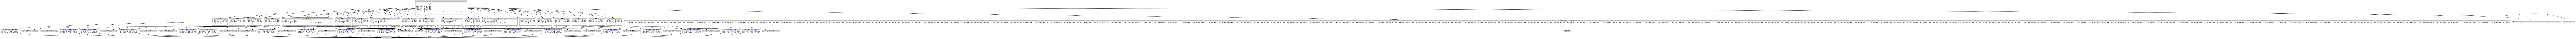

In [86]:
 import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

In [182]:
from pyld import jsonld
import json


with open('../data/routes.json', 'r') as myfile:
    data=myfile.read()
jj = json.loads(data)

compacted = jsonld.compact(jj, context)


print(json.dumps(compacted, indent=2))
# Output:
# {
#   "@context": {...},
#   "image": "http://manu.sporny.org/images/manu.png",
#   "homepage": "http://manu.sporny.org/",
#   "name": "Manu Sporny"
# }


{
  "@context": {
    "@vocab": "http://purl.org/dc/terms/",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    "owl": "http://www.w3.org/2002/07/owl#",
    "schema": "https://schema.org/",
    "qudt": "http://qudt.org/vocab/unit/",
    "smk": "https://hevs.ch/data/smoking-cessation/",
    "arg": "https://hevs.ch/ontology/argumentation#",
    "@language": "en"
  },
  "@graph": [
    {
      "@id": "https://hevs.ch/santour/anniviers/pod_839",
      "@type": [
        "https://hevs.ch/ontology/santour#PointOfDifficulty",
        "schema:Place"
      ],
      "schema:amenityFeature": [
        {
          "@id": "_:N8c56558a4b36432c857af96a44ed2002"
        },
        {
          "@id": "_:Nca8fb75aabc7442a92f47e5022c5889d"
        },
        {
          "@id": "_:N7ef84585f96c4bda9adde7bec5ef42d7"
        },
        {
          "@id": "_:N726d342e42704c5085377b787ec55633"
        }
      ],
      "schema:description": {
        "@value": ""
      },
      "schema:geo": [
        {
